In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')
warnings.filterwarnings('ignore')

In [2]:
# 한글꺠지는 것 방지
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# Data Loading

In [3]:
demo = pd.read_csv('C:/Users/wnrrh/Desktop/태준/롯데멤버스/LPOINT_BIG_COMP_01_DEMO.csv', encoding = 'utf-8', delimiter = ',')
pdde = pd.read_csv('C:/Users/wnrrh/Desktop/태준/롯데멤버스/LPOINT_BIG_COMP_02_PDDE.csv', encoding = 'utf-8', delimiter = ',')
copu = pd.read_csv('C:/Users/wnrrh/Desktop/태준/롯데멤버스/LPOINT_BIG_COMP_03_COP_U.csv', encoding = 'utf-8', delimiter = ',')
clac = pd.read_csv('C:/Users/wnrrh/Desktop/태준/롯데멤버스/LPOINT_BIG_COMP_04_PD_CLAC.csv', encoding = 'utf-8', delimiter = ',')
br = pd.read_csv('C:/Users/wnrrh/Desktop/태준/롯데멤버스/LPOINT_BIG_COMP_05_BR.csv', encoding = 'utf-8', delimiter = ',')
lpay = pd.read_csv('C:/Users/wnrrh/Desktop/태준/롯데멤버스/LPOINT_BIG_COMP_06_LPAY.csv', encoding = 'utf-8', delimiter = ',')

In [4]:
demo.rename(columns={'cust':'고객코드', 'ma_fem_dv':'성별', 'ages':'연령대', 'zon_hlv':'거주지대분류코드'},inplace=True)
pdde.rename(columns = {'cust':'고객코드', 'rct_no':'영수증번호', 'chnl_dv':'채널구분', 'cop_c':'제휴사', 'br_c':'점포코드', 'pd_c':'상품코드', 'de_dt':'구매일자', 'de_hr':'구매시간', 'buy_am':'구매금액', 'buy_ct':'구매수량'}, inplace=True)
copu.rename(columns = {'cust':'고객코드', 'rct_no':'영수증번호', 'chnl_dv':'채널구분', 'cop_c':'제휴사', 'br_c':'점포코드', 'pd_c':'상품코드', 'de_dt':'구매일자', 'vst_dt':'제휴사 방문일자', 'de_hr':'구매시간', 'buy_am':'구매금액'}, inplace=True)
clac.rename(columns = {'pd_c':'상품코드','pd_nm':'상품 소분류명', 'clac_hlv_nm':'상품 대분류명','clac_mcls_nm':'상품 중분류명'},inplace=True)
br.rename(columns = {'br_c':'점포코드', 'cop_c':'제휴사', 'zon_hlv':'점포지역대분류코드','zon_mcls':'점포지역중분류코드'},inplace=True)
lpay.rename(columns = {'cust':'고객코드','rct_no':'영수증번호', 'cop_c':'제휴사', 'chnl_dv':'채널구분','de_dt':'구매일자', 'de_hr':'구매시간', 'buy_am':'구매금액'},inplace=True)

<AxesSubplot:>

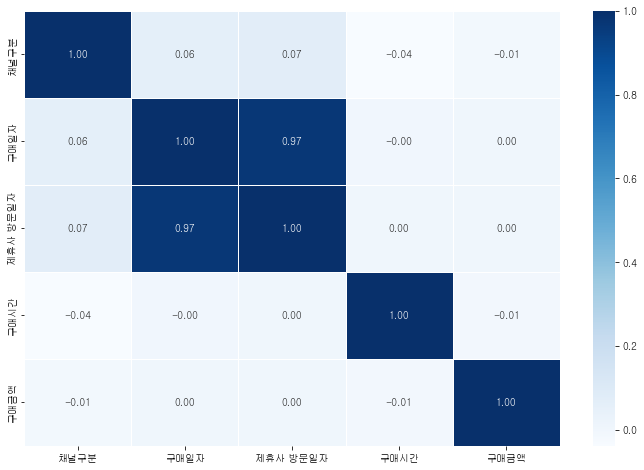

In [5]:
# 제휴사 방문일자와 구매일자 간의 관계 매우 높기에 제휴사 방문일자 컬럼 제거
plt.figure(figsize=(12,8))
sns.heatmap(data = copu.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

구매일자와 제휴사 방문일자는 동일하다고 봐도 무방.

# DataFrame 통일

## 유통사 DF

In [6]:
pdde = pd.merge(pdde,demo, on = ['고객코드'], how = 'left')

In [7]:
pdde = pd.merge(pdde,clac, on = ['상품코드'], how = 'left')

In [8]:
pdde = pd.merge(pdde, br, on = ['점포코드', '제휴사'], how = 'left')

### 유통사 내 전체 row값이 중복되는 row 제거

In [9]:
# 한 row 내 모든 데이터 값이 동일한 row인 경우 중복제거 처리 첫값은 False, 이후 중복되면 True
dupli_row = pdde.duplicated(['고객코드','영수증번호','채널구분','제휴사','점포코드','상품코드','구매일자','구매시간','구매금액','구매수량','성별','연령대','거주지대분류코드','점포지역대분류코드','점포지역중분류코드','상품 소분류명','상품 대분류명', '상품 중분류명'], keep='first')

In [10]:
pdde = pd.concat([pdde, dupli_row], axis=1)

In [11]:
# 중복된 row 개수 확인
pdde[0].value_counts()

False    4144389
True      237354
Name: 0, dtype: int64

In [12]:
# 중복값 제거 
pdde.rename(columns = {0:'중복값 기준'},inplace=True)

idx = pdde[pdde['중복값 기준'] == True].index
pdde.drop(idx, axis=0, inplace=True)
pdde.reset_index(drop=True , inplace=True)

pdde.drop(['중복값 기준'], axis=1, inplace=True)

## 제휴사 DF

In [13]:
copu = pd.merge(copu, demo, on = ['고객코드'], how = 'left')
copu = pd.merge(copu, br, on = ['점포코드', '제휴사'], how = 'left')

## 유통사, 제휴사에 엘페이 매칭

In [14]:
# 엘페이 데이터 demo와 매칭
lpay = pd.merge(lpay, demo, on = ['고객코드'], how = 'left')

In [15]:
lpay['엘페이결제여부'] = 1
lpay.drop(['영수증번호'], axis=1, inplace=True)

### 엘페이와 그냥 merge하게 되면, row 수가 늘어나는 상황 발생!! 따라서 인덱스로 duplicated 실행

#### 유통사 데이터 먼저 lpay merge

In [16]:
pdde.reset_index(drop=False, inplace=True)
df_product = pd.merge(pdde, lpay, on = ['고객코드','채널구분','제휴사','구매일자','구매시간','구매금액','성별','연령대','거주지대분류코드'], how = 'left')

In [17]:
df_product.drop_duplicates(['index'], keep='first',inplace=True)
df_product.reset_index(drop=True,inplace=True)

In [18]:
df_product.drop(['index'], axis=1, inplace=True)

In [19]:
pdde = df_product.copy()

#### 제휴사 데이터와 lpay merge

In [20]:
copu.reset_index(drop=False, inplace=True)
copu = pd.merge(copu, lpay, on = ['고객코드','채널구분','제휴사','구매일자','구매시간','구매금액','성별','연령대','거주지대분류코드'], how = 'left')

In [21]:
copu.drop_duplicates(['index'], keep='first',inplace=True)
copu.reset_index(drop=True,inplace=True)

In [22]:
copu.drop(['index', '제휴사 방문일자'], axis=1, inplace=True)

# Preprocessing

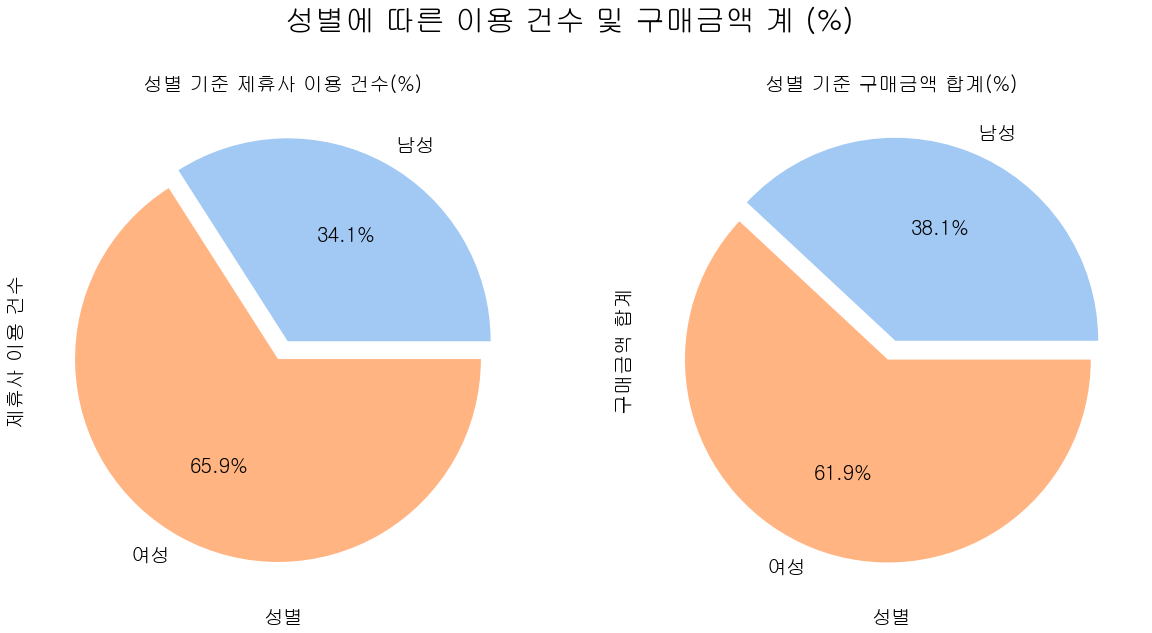

In [23]:
# 성별에 따른 제휴사 이용 건수 및 구매금액 
color = sns.color_palette('pastel')[:10]
a = copu.groupby("성별")["고객코드"].count()
b = copu.groupby("성별")["구매금액"].sum()

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title("성별 기준 제휴사 이용 건수(%)", fontsize=20)

a.plot(kind = 'pie', explode = [0.05, 0.05], autopct='%1.1f%%', textprops={'fontsize':20}, colors=color)
plt.xlabel('성별', fontsize=20)
plt.ylabel('제휴사 이용 건수',fontsize=20)

plt.subplot(1,2,2)
plt.title("성별 기준 구매금액 합계(%)", fontsize=20)

b.plot(kind = 'pie', explode = [0.05, 0.05], autopct='%1.1f%%', textprops={'fontsize' : 20}, colors=color)
plt.xlabel('성별', fontsize=20)
plt.ylabel('구매금액 합계', fontsize=20)

plt.suptitle('성별에 따른 이용 건수 및 구매금액 계 (%)', fontsize = 30)
plt.show()

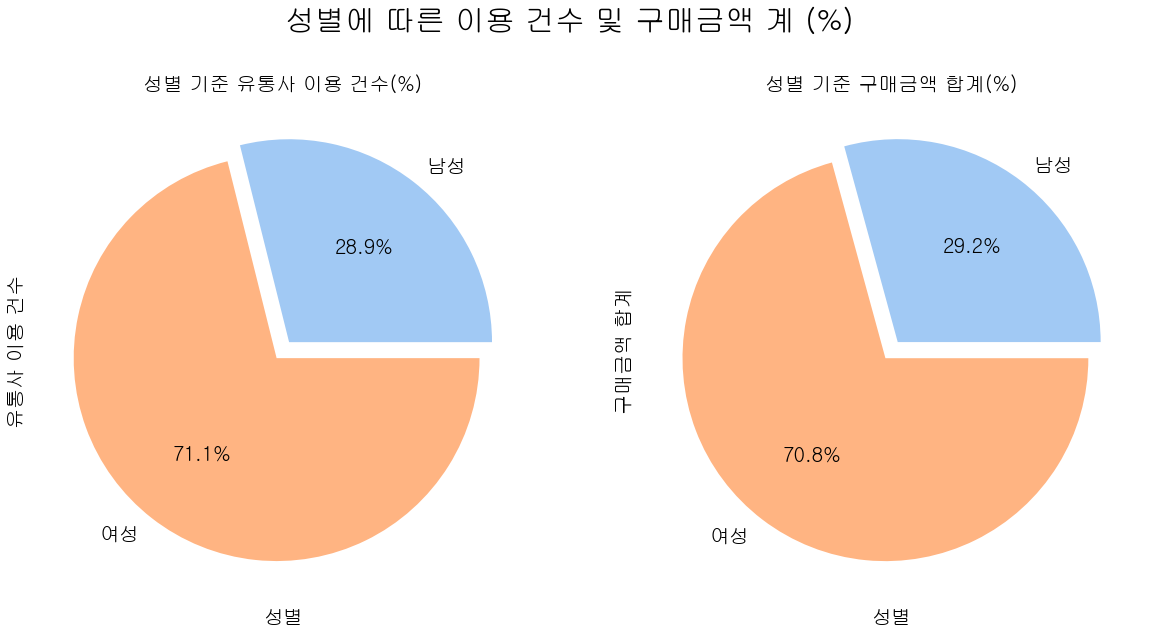

In [24]:
# 성별에 따른 유통사 이용 건수 및 구매금액 
color = sns.color_palette('pastel')[:10]
a = pdde.groupby("성별")["고객코드"].count()
b = pdde.groupby("성별")["구매금액"].sum()

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title("성별 기준 유통사 이용 건수(%)", fontsize=20)

a.plot(kind = 'pie', explode = [0.05, 0.05], autopct='%1.1f%%', textprops={'fontsize':20}, colors=color)
plt.xlabel('성별', fontsize=20)
plt.ylabel('유통사 이용 건수',fontsize=20)

plt.subplot(1,2,2)
plt.title("성별 기준 구매금액 합계(%)", fontsize=20)

b.plot(kind = 'pie', explode = [0.05, 0.05], autopct='%1.1f%%', textprops={'fontsize' : 20}, colors=color)
plt.xlabel('성별', fontsize=20)
plt.ylabel('구매금액 합계', fontsize=20)

plt.suptitle('성별에 따른 이용 건수 및 구매금액 계 (%)', fontsize = 30)
plt.show()

In [25]:
pdde['성별'] = pdde['성별'].replace('여성',0)
pdde['성별'] = pdde['성별'].replace('남성',1)
copu['성별'] = copu['성별'].replace('여성',0)
copu['성별'] = copu['성별'].replace('남성',1)

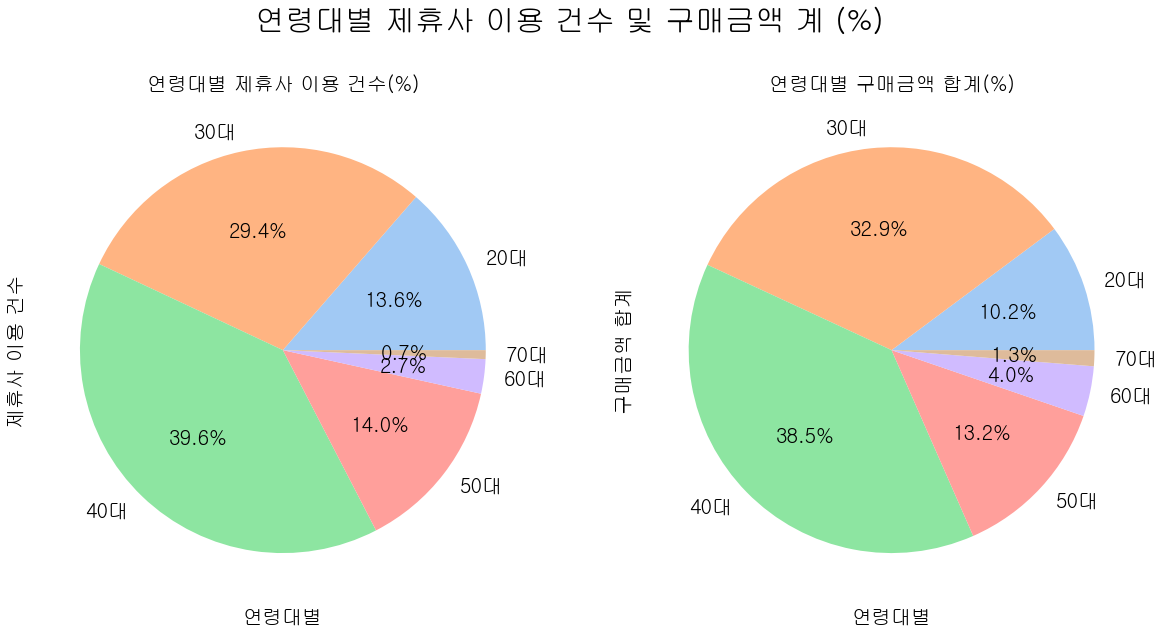

In [26]:
# 연령대별 제휴사 이용 건수 및 구매금액 합계
a = copu.groupby("연령대")["고객코드"].count()
b = copu.groupby("연령대")["구매금액"].sum()

plt.figure(figsize =(20,10))

plt.subplot(1,2,1)
plt.title("연령대별 제휴사 이용 건수(%)", fontsize=20)
a.plot(kind = 'pie', autopct='%1.1f%%', textprops= {'fontsize':20}, colors=color)
plt.xlabel('연령대별', fontsize=20)
plt.ylabel('제휴사 이용 건수',fontsize=20)

plt.subplot(1,2,2)
plt.title("연령대별 구매금액 합계(%)", fontsize=20)
b.plot(kind = 'pie', autopct='%1.1f%%', textprops= {'fontsize':20}, colors=color)
plt.xlabel('연령대별', fontsize=20)
plt.ylabel('구매금액 합계', fontsize=20)

plt.suptitle('연령대별 제휴사 이용 건수 및 구매금액 계 (%)', fontsize = 30)
plt.show()

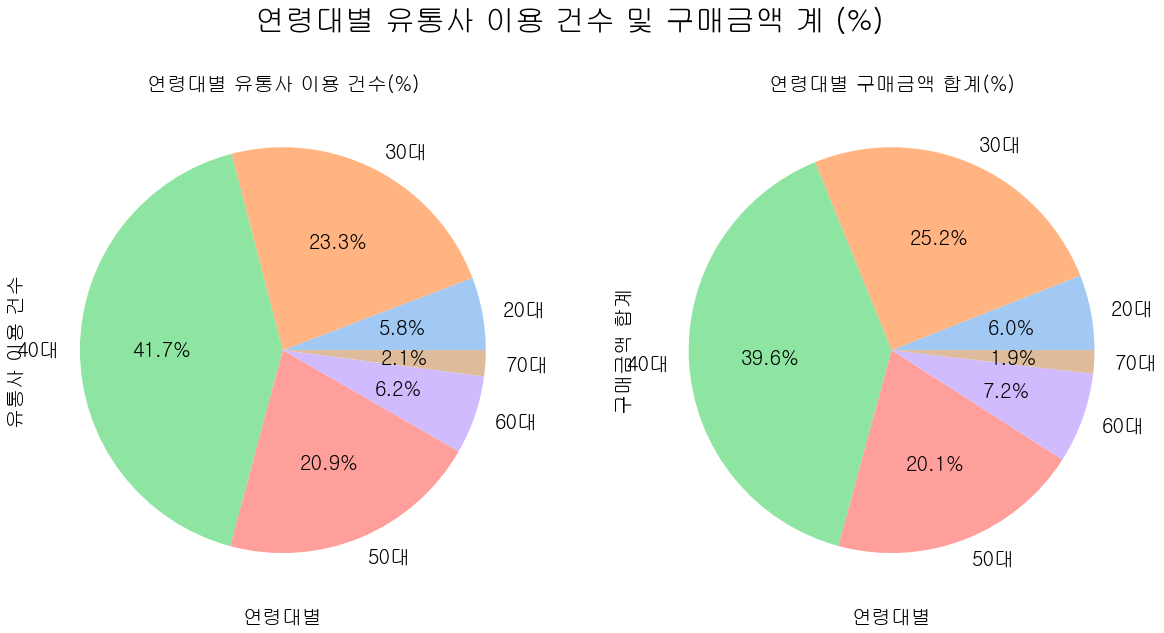

In [27]:
# 연령대별 유통사 이용 건수 및 구매금액 합계
a = pdde.groupby("연령대")["고객코드"].count()
b = pdde.groupby("연령대")["구매금액"].sum()

plt.figure(figsize =(20,10))

plt.subplot(1,2,1)
plt.title("연령대별 유통사 이용 건수(%)", fontsize=20)
a.plot(kind = 'pie', autopct='%1.1f%%', textprops= {'fontsize':20}, colors=color)
plt.xlabel('연령대별', fontsize=20)
plt.ylabel('유통사 이용 건수',fontsize=20)

plt.subplot(1,2,2)
plt.title("연령대별 구매금액 합계(%)", fontsize=20)
b.plot(kind = 'pie', autopct='%1.1f%%', textprops= {'fontsize':20}, colors=color)
plt.xlabel('연령대별', fontsize=20)
plt.ylabel('구매금액 합계', fontsize=20)

plt.suptitle('연령대별 유통사 이용 건수 및 구매금액 계 (%)', fontsize = 30)
plt.show()

In [28]:
# 연령대 형태 변환
def change_age(text:str):
    return text[:2]

copu['연령대'] = copu['연령대'].map(change_age).astype(int)
pdde['연령대'] = pdde['연령대'].map(change_age).astype(int)

In [29]:
pdde['엘페이결제여부'].fillna(0, inplace = True)
copu['엘페이결제여부'].fillna(0, inplace = True)

In [30]:
pdde['엘페이결제여부'] = pdde['엘페이결제여부'].astype('int')
pdde['구매금액'] = pdde['구매금액'].astype('int')
copu['엘페이결제여부'] = copu['엘페이결제여부'].astype('int')
copu['구매금액'] = copu['구매금액'].astype('int')

In [31]:
pdde.isnull().sum()

고객코드              0
영수증번호             0
채널구분              0
제휴사               0
점포코드         375784
상품코드              0
구매일자              0
구매시간              0
구매금액              0
구매수량              0
성별                0
연령대               0
거주지대분류코드          0
상품 소분류명           0
상품 대분류명           0
상품 중분류명           0
점포지역대분류코드    375784
점포지역중분류코드    375784
엘페이결제여부           0
dtype: int64

In [32]:
copu.isnull().sum()

고객코드          0
영수증번호         0
제휴사           0
점포코드         55
채널구분          0
구매일자          0
구매시간          0
구매금액          0
성별            0
연령대           0
거주지대분류코드      0
점포지역대분류코드    55
점포지역중분류코드    55
엘페이결제여부       0
dtype: int64

1. 유통사의 경우 채널이 온라인이면 >> 결측치 발생(점포관련 컬럼 : NaN)
2. 제휴사의 경우 채널이 온라인이며, 일부 데이터만 결측치 발생(점포관련 컬럼 : NaN)

따라서 두 DataFrame에 '미기입'으로 결측치 채워줌.

In [33]:
pdde.fillna('미기입', inplace=True)
copu.fillna('미기입', inplace=True)

In [34]:
df_pdde = pdde.drop(['고객코드', '영수증번호'], axis=1)
df_copu = copu.drop(['고객코드', '영수증번호'], axis=1)

고객코드 영수증번호 살리고 싶으시면 pdde, copu DF명 사용해서 하시면 됩니다~

In [35]:
# 바로배송 가능 컬럼 생성
for i in pdde.index:
    if pdde.loc[i,'거주지대분류코드'] == pdde.loc[i,'점포지역대분류코드'] :
        pdde.loc[i,'바로배송가능지역'] = 1
    else :
        pdde.loc[i,'바로배송가능지역'] = 0
        
for i in copu.index:
    if copu.loc[i,'거주지대분류코드'] == copu.loc[i,'점포지역대분류코드']:
        copu.loc[i,'바로배송가능지역'] = 1
    else :
        copu.loc[i,'바로배송가능지역'] = 0

In [36]:
pdde.drop(['거주지대분류코드', '점포지역대분류코드'],axis=1, inplace=True)
copu.drop(['거주지대분류코드', '점포지역대분류코드'],axis=1, inplace=True)

In [37]:
pdde['바로배송가능지역'] = pdde['바로배송가능지역'].astype('int')
copu['바로배송가능지역'] = copu['바로배송가능지역'].astype('int')

In [38]:
# 구매일자 컬럼 연/월/일/요일 컬럼으로 구분
pdde['구매일자'] = pdde['구매일자'].astype('str')
pdde['구매일자'] = pdde['구매일자'].str[0:4] + '-' + pdde['구매일자'].str[4:6] + '-' + pdde['구매일자'].str[6:]
copu['구매일자'] = copu['구매일자'].astype('str')
copu['구매일자'] = copu['구매일자'].str[0:4] + '-' + copu['구매일자'].str[4:6] + '-' + copu['구매일자'].str[6:]

In [39]:
pdde['구매일자'] = pd.to_datetime(pdde['구매일자'])
copu['구매일자'] = pd.to_datetime(copu['구매일자'])

In [40]:
import datetime as dt
pdde['구매년도'] = pdde['구매일자'].dt.year
pdde['구매월'] = pdde['구매일자'].dt.month
pdde['구매일'] = pdde['구매일자'].dt.day
pdde['구매요일'] = pdde['구매일자'].dt.dayofweek # 월요일0 / 화요일1 / 수요일2 ~ 6까지
copu['구매년도'] = copu['구매일자'].dt.year
copu['구매월'] = copu['구매일자'].dt.month
copu['구매일'] = copu['구매일자'].dt.day
copu['구매요일'] = copu['구매일자'].dt.dayofweek

In [41]:
pdde = pdde.drop(['구매일자'],axis=1)
copu = copu.drop(['구매일자'],axis=1)

In [42]:
# 결과 해석 EDA를 위한 DF copy 
df_pdde = pdde.copy()
df_copu = copu.copy()

## 구매일자 컬럼 관련 EDA

<AxesSubplot:>

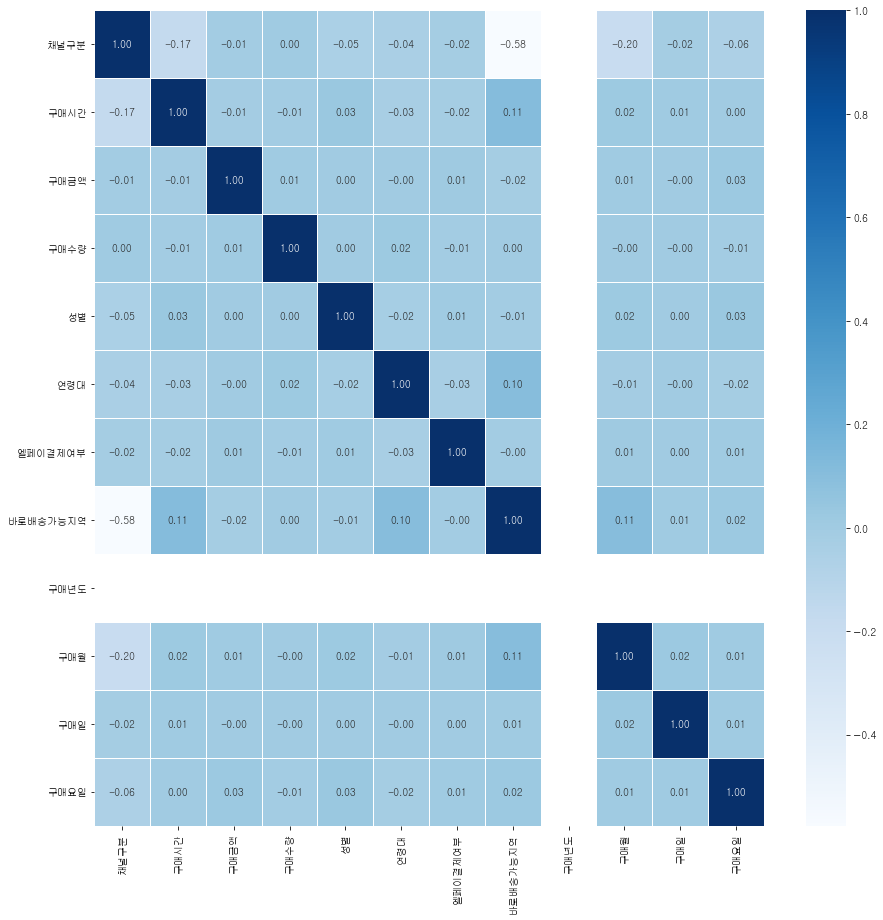

In [43]:
# 유통사
plt.figure(figsize=(15,15))
sns.heatmap(data = df_pdde.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

<AxesSubplot:>

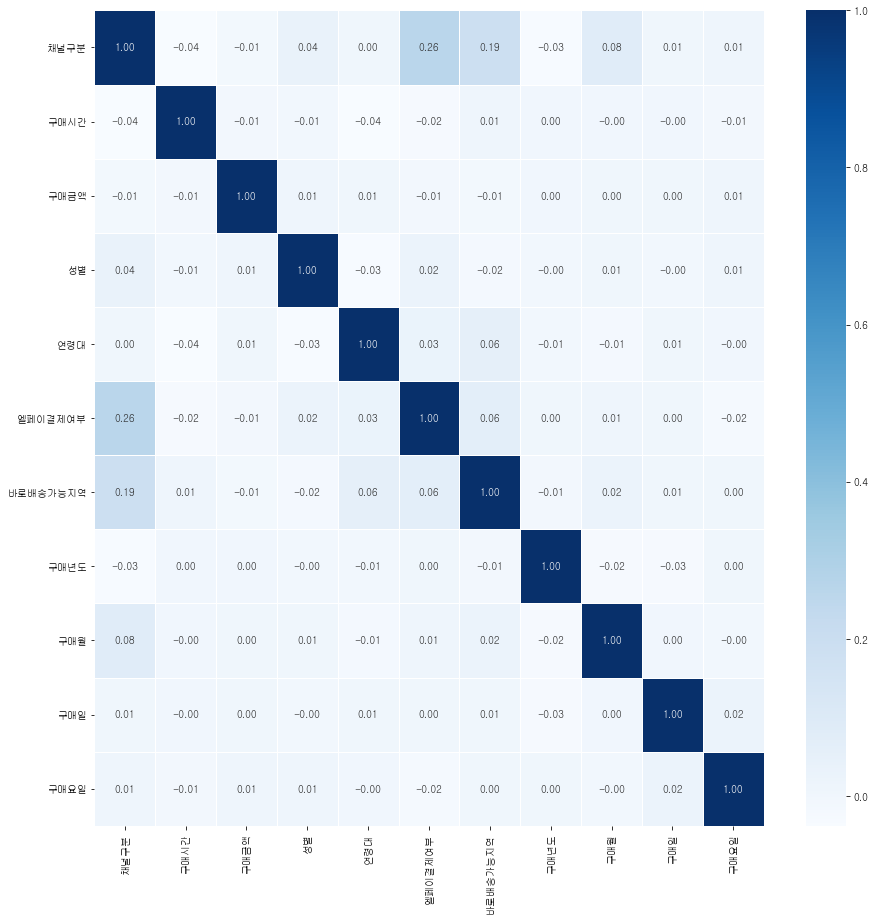

In [44]:
# 제휴사
plt.figure(figsize=(15,15))
sns.heatmap(data = df_copu.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

# Modeling - CatBoost 

In [45]:
# Catboost용 데이터프레임 생성
df_pdde2 = df_pdde.copy()
df_copu2 = df_copu.copy()

In [46]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import KFold
from functools import partial
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score

In [5]:
cat_features = ['제휴사','점포코드','상품코드','상품 소분류명', '상품 중분류명', '상품 대분류명', '점포지역중분류코드']
pdde_x = df_pdde2.drop(['엘페이결제여부'],axis=1)
pdde_y = df_pdde2['엘페이결제여부']

In [6]:
pdde_x_train, pdde_x_test, pdde_y_train, pdde_y_test = train_test_split(pdde_x,pdde_y, stratify = pdde_y, test_size=0.2)
pdde_x_train, pdde_x_valid, pdde_y_train, pdde_y_valid = train_test_split(pdde_x_train,pdde_y_train, stratify = pdde_y_train, test_size=0.2)

In [7]:
model_clf = CatBoostClassifier(learning_rate=0.05, eval_metric = 'AUC')
model_clf.fit(pdde_x_train, pdde_y_train, eval_set=[(pdde_x_train, pdde_y_train), (pdde_x_valid, pdde_y_valid)], early_stopping_rounds=50, cat_features=cat_features, verbose=100)

0:	test: 0.7598576	test1: 0.7574734	best: 0.7574734 (0)	total: 2.79s	remaining: 46m 29s
100:	test: 0.9277376	test1: 0.9050384	best: 0.9050384 (100)	total: 3m 11s	remaining: 28m 27s
200:	test: 0.9361022	test1: 0.9103102	best: 0.9103102 (200)	total: 8m	remaining: 31m 50s
300:	test: 0.9390490	test1: 0.9127439	best: 0.9127439 (300)	total: 13m 5s	remaining: 30m 24s
400:	test: 0.9406384	test1: 0.9140166	best: 0.9140166 (400)	total: 17m 43s	remaining: 26m 29s
500:	test: 0.9428448	test1: 0.9155422	best: 0.9155422 (500)	total: 22m 16s	remaining: 22m 11s
600:	test: 0.9439114	test1: 0.9164359	best: 0.9164359 (600)	total: 26m 43s	remaining: 17m 44s
700:	test: 0.9450561	test1: 0.9172529	best: 0.9172529 (700)	total: 31m 18s	remaining: 13m 21s
800:	test: 0.9458185	test1: 0.9178767	best: 0.9178785 (799)	total: 35m 46s	remaining: 8m 53s
900:	test: 0.9466600	test1: 0.9184042	best: 0.9184042 (900)	total: 40m 33s	remaining: 4m 27s
999:	test: 0.9474416	test1: 0.9187394	best: 0.9187394 (999)	total: 45m 23s	

In [16]:
pdde_y_pred = model_clf.predict(pdde_x_test)

In [18]:
f1 = f1_score(pdde_y_test, pdde_y_pred) 
roc_auc = roc_auc_score(pdde_y_test, pdde_y_pred) 
print("F1 Score: {}".format(f1))
print("ROC AUC Score: {}".format(roc_auc))

F1 Score: 0.10444726810673442
ROC AUC Score: 0.5278768796790949


In [9]:
cat_features2 = ['제휴사', '점포코드', '점포지역중분류코드']
copu_x = df_copu2.drop(['엘페이결제여부'],axis=1)
copu_y = df_copu2['엘페이결제여부']

In [14]:
copu_x_train, copu_x_test, copu_y_train, copu_y_test = train_test_split(copu_x, copu_y, stratify = copu_y, test_size=0.2)
copu_x_train, copu_x_valid, copu_y_train, copu_y_valid = train_test_split(copu_x_train, copu_y_train, stratify = copu_y_train, test_size=0.2)

In [15]:
model_clf2 = CatBoostClassifier(learning_rate=0.05, eval_metric = 'AUC')
model_clf2.fit(copu_x_train, copu_y_train, eval_set=[(copu_x_train, copu_y_train), (copu_x_valid, copu_y_valid)], early_stopping_rounds=50, cat_features=cat_features2, verbose=100)

0:	test: 0.7022836	test1: 0.7068140	best: 0.7068140 (0)	total: 74.9ms	remaining: 1m 14s
100:	test: 0.8405429	test1: 0.8286832	best: 0.8286832 (100)	total: 9.04s	remaining: 1m 20s
200:	test: 0.8570528	test1: 0.8403401	best: 0.8403401 (200)	total: 19.3s	remaining: 1m 16s
300:	test: 0.8674838	test1: 0.8469035	best: 0.8469035 (300)	total: 31.6s	remaining: 1m 13s
400:	test: 0.8750862	test1: 0.8512891	best: 0.8512891 (400)	total: 44.9s	remaining: 1m 7s
500:	test: 0.8806995	test1: 0.8541120	best: 0.8541120 (500)	total: 58s	remaining: 57.8s
600:	test: 0.8844083	test1: 0.8556692	best: 0.8556692 (600)	total: 1m 11s	remaining: 47.3s
700:	test: 0.8886023	test1: 0.8571743	best: 0.8571743 (700)	total: 1m 23s	remaining: 35.6s
800:	test: 0.8929375	test1: 0.8587621	best: 0.8587621 (800)	total: 1m 35s	remaining: 23.7s
900:	test: 0.8957062	test1: 0.8597565	best: 0.8597565 (900)	total: 1m 46s	remaining: 11.7s
999:	test: 0.8983894	test1: 0.8606978	best: 0.8607032 (998)	total: 1m 58s	remaining: 0us

bestTes

In [19]:
copu_y_pred = model_clf2.predict(copu_x_test)

In [20]:
f1 = f1_score(copu_y_test, copu_y_pred) 
roc_auc = roc_auc_score(copu_y_test, copu_y_pred) 
print("F1 Score: {}".format(f1))
print("ROC AUC Score: {}".format(roc_auc))

F1 Score: 0.3135608687716737
ROC AUC Score: 0.597336358921505


타겟 변수 자체의 수가 적고, 불균형으로 인해 샘플링의 필요성을 느낌.

# 유통사 데이터 전처리

In [47]:
점포코드list = df_pdde['점포코드'].value_counts().head(16)
상품코드list = df_pdde['상품코드'].value_counts().head(21)
상품대분류명list = df_pdde['상품 대분류명'].value_counts().head(24)
점포지역중분류list = df_pdde['점포지역중분류코드'].value_counts().head(20)

점포코드, 상품코드는 30000개 이하면 기타로 처리, 지역대분류코드, 제휴사는 전부 인코딩, 

점포지역중분류코드 50000개 이하면 기타로 처리

상품 대분류명 50000개 이하인 경우 기타로 처리

In [48]:
# 인코딩 전 상품 중분류명, 소분류명 제거
df_pdde.drop(['상품 소분류명', '상품 중분류명'],axis=1, inplace=True)

In [49]:
for i in df_pdde.index:
    if df_pdde.loc[i, '점포코드'] not in (점포코드list) :
        df_pdde.loc[i,'점포코드'] = '기타'
    if df_pdde.loc[i,'상품코드'] not in 상품코드list :
        df_pdde.loc[i,'상품코드'] = '기타'
    if df_pdde.loc[i, '상품 대분류명'] not in 상품대분류명list :
        df_pdde.loc[i,'상품 대분류명'] = '기타'
    if df_pdde.loc[i,'점포지역중분류코드'] not in 점포지역중분류list :
        df_pdde.loc[i,'점포지역중분류코드'] = '기타'

In [50]:
df_pdde

,고객코드,영수증번호,채널구분,제휴사,점포코드,상품코드,구매시간,구매금액,구매수량,성별,연령대,상품 대분류명,점포지역중분류코드,엘페이결제여부,바로배송가능지역,구매년도,구매월,구매일,구매요일
0,M430112881,A01000001113,1,A01,기타,기타,10,15000,1,0,50,남성의류,기타,0,0,2021,1,1,4
1,M646853852,A01000002265,1,A01,기타,기타,10,79700,1,0,40,주방잡화,Z13001,0,1,2021,1,1,4
2,M430112881,A01000003148,1,A01,기타,기타,10,19000,1,0,50,남성의류,기타,0,0,2021,1,1,4
3,M430112881,A01000004946,1,A01,기타,기타,10,19000,1,0,50,남성의류,기타,0,0,2021,1,1,4
4,M430112881,A01000005297,1,A01,기타,기타,10,9900,1,0,50,테넌트/음식점,기타,0,0,2021,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144384,M816318679,E06052115831,2,A06,미기입,기타,22,50000,1,0,40,기타,미기입,0,0,2021,12,31,4
4144385,M816318679,E06052116037,2,A06,미기입,기타,22,10000,1,0,40,기타,미기입,0,0,2021,12,31,4
4144386,M182645944,E06052117103,2,A06,미기입,기타,23,289000,1,1,20,남성의류,미기입,0,0,2021,12,31,4
4144387,M533286446,E06052118403,2,A06,미기입,기타,23,200000,1,1,40,기타,미기입,0,0,2021,12,31,4


# 제휴사 데이터 전처리

In [52]:
제휴사점포코드list = df_copu.점포코드.value_counts().head(20)
제휴사점포지역중분류list = df_copu['점포지역중분류코드'].value_counts().head(24)

점포코드의 경우 1000개 이하면 기타로 처리

점포지역중분류코드의 경우 2000개 이하면 기타로 처리

지역대분류코드의 경우 전부 인코딩

In [53]:
for i in df_copu.index:
    if df_copu.loc[i,'점포코드'] not in 제휴사점포코드list:
        df_copu.loc[i, '점포코드'] = '기타'
    if df_copu.loc[i,'점포지역중분류코드'] not in 제휴사점포지역중분류list:
        df_copu.loc[i, '점포지역중분류코드'] = '기타'

In [54]:
df_copu

,고객코드,영수증번호,제휴사,점포코드,채널구분,구매시간,구매금액,성별,연령대,점포지역중분류코드,엘페이결제여부,바로배송가능지역,구매년도,구매월,구매일,구매요일
0,M839993508,21102612B015763935,B01,B010012,1,12,60000,1,70,Z17024,0,1,2021,10,26,1
1,M839993508,21110610B014219744,B01,B010012,1,10,17100,1,70,Z17024,0,1,2021,11,6,5
2,M839993508,21021112B013419710,B01,B010012,1,12,136500,1,70,Z17024,0,1,2021,2,11,3
3,M839993508,21092010B012637545,B01,B010012,1,10,34200,1,70,Z17024,0,1,2021,9,20,0
4,M839993508,21101009D015920171,D01,기타,1,9,2500,1,70,Z17018,0,1,2021,10,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248299,M058650684,21111614C021426818,C02,C020002,1,14,2000,0,20,Z17018,0,0,2021,11,16,1
248300,M058650684,21111619C023223432,C02,C020002,1,19,26900,0,20,Z17018,0,0,2021,11,16,1
248301,M014154595,21121209C015324520,C01,기타,2,9,2000,0,30,기타,0,0,2021,12,12,6
248302,M510878172,21112719C013369102,C01,기타,2,19,6000,1,20,Z17013,0,1,2021,11,27,5


# Encoding 

인코딩 후, 언더샘플링으로 class 불균형 맞춰준 이후 >> 개별 모델링 진행

In [55]:
# 가변수 설정하기 
df_pdde = pd.get_dummies(df_pdde, columns = ['제휴사', '점포코드', '상품코드', '상품 대분류명','점포지역중분류코드'])

In [70]:
df_pdde

,고객코드,영수증번호,채널구분,구매시간,구매금액,구매수량,성별,연령대,엘페이결제여부,바로배송가능지역,...,점포지역중분류코드_Z17001,점포지역중분류코드_Z17004,점포지역중분류코드_Z17009,점포지역중분류코드_Z17011,점포지역중분류코드_Z17018,점포지역중분류코드_Z17020,점포지역중분류코드_Z17022,점포지역중분류코드_Z17024,점포지역중분류코드_기타,점포지역중분류코드_미기입
0,M430112881,A01000001113,1,10,15000,1,0,50,0,0,...,0,0,0,0,0,0,0,0,1,0
1,M646853852,A01000002265,1,10,79700,1,0,40,0,1,...,0,0,0,0,0,0,0,0,0,0
2,M430112881,A01000003148,1,10,19000,1,0,50,0,0,...,0,0,0,0,0,0,0,0,1,0
3,M430112881,A01000004946,1,10,19000,1,0,50,0,0,...,0,0,0,0,0,0,0,0,1,0
4,M430112881,A01000005297,1,10,9900,1,0,50,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144384,M816318679,E06052115831,2,22,50000,1,0,40,0,0,...,0,0,0,0,0,0,0,0,0,1
4144385,M816318679,E06052116037,2,22,10000,1,0,40,0,0,...,0,0,0,0,0,0,0,0,0,1
4144386,M182645944,E06052117103,2,23,289000,1,1,20,0,0,...,0,0,0,0,0,0,0,0,0,1
4144387,M533286446,E06052118403,2,23,200000,1,1,40,0,0,...,0,0,0,0,0,0,0,0,0,1


In [57]:
df_copu = pd.get_dummies(df_copu, columns = ['제휴사', '점포코드','점포지역중분류코드'])

In [71]:
df_copu

,고객코드,영수증번호,채널구분,구매시간,구매금액,성별,연령대,엘페이결제여부,바로배송가능지역,구매년도,...,점포지역중분류코드_Z17005,점포지역중분류코드_Z17006,점포지역중분류코드_Z17009,점포지역중분류코드_Z17011,점포지역중분류코드_Z17013,점포지역중분류코드_Z17018,점포지역중분류코드_Z17020,점포지역중분류코드_Z17021,점포지역중분류코드_Z17024,점포지역중분류코드_기타
0,M839993508,21102612B015763935,1,12,60000,1,70,0,1,2021,...,0,0,0,0,0,0,0,0,1,0
1,M839993508,21110610B014219744,1,10,17100,1,70,0,1,2021,...,0,0,0,0,0,0,0,0,1,0
2,M839993508,21021112B013419710,1,12,136500,1,70,0,1,2021,...,0,0,0,0,0,0,0,0,1,0
3,M839993508,21092010B012637545,1,10,34200,1,70,0,1,2021,...,0,0,0,0,0,0,0,0,1,0
4,M839993508,21101009D015920171,1,9,2500,1,70,0,1,2021,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248299,M058650684,21111614C021426818,1,14,2000,0,20,0,0,2021,...,0,0,0,0,0,1,0,0,0,0
248300,M058650684,21111619C023223432,1,19,26900,0,20,0,0,2021,...,0,0,0,0,0,1,0,0,0,0
248301,M014154595,21121209C015324520,2,9,2000,0,30,0,0,2021,...,0,0,0,0,0,0,0,0,0,1
248302,M510878172,21112719C013369102,2,19,6000,1,20,0,1,2021,...,0,0,0,0,1,0,0,0,0,0


In [72]:
df_pdde_cat = df_pdde.copy()
df_copu_cat = df_copu.copy()

In [ ]:
df_pdde.drop(['고객코드','영수증번호'],axis=1,inplace=True)
df_copu.drop(['고객코드','영수증번호'],axis=1,inplace=True)

In [4]:
df_pdde = pd.read_csv('C:/Users/wnrrh/Desktop/유통사_데이터.csv',encoding = 'utf-8', delimiter = ',')
df_copu = pd.read_csv('C:/Users/wnrrh/Desktop/제휴사_데이터.csv',encoding = 'utf-8', delimiter = ',')

# Modeling - RandomForest

In [5]:
# 모델링 라이브러리
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score, accuracy_score, average_precision_score # Evaluation
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestRegressor

In [6]:
pdde_x = df_pdde.drop(['엘페이결제여부'],axis=1) 
pdde_y = df_pdde['엘페이결제여부']
copu_x = df_copu.drop(['엘페이결제여부'],axis=1)
copu_y = df_copu['엘페이결제여부']

## 유통사 모델링 - Under Sampling & RandomForest

In [7]:
from imblearn.under_sampling import RandomUnderSampler
유통사_x_under, 유통사_y_under = RandomUnderSampler(random_state = 0).fit_resample(pdde_x, pdde_y)

In [8]:
유통사_y_under = pd.DataFrame(유통사_y_under)

In [9]:
from sklearn.model_selection import train_test_split
유통사_x_train, 유통사_x_test, 유통사_y_train, 유통사_y_test = train_test_split(유통사_x_under, 유통사_y_under, test_size=0.2, stratify = 유통사_y_under)

In [10]:
print(유통사_y_under.value_counts())

엘페이결제여부
0          36777
1          36777
dtype: int64


In [11]:
pdde_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4144389 entries, 0 to 4144388
Columns: 102 entries, 채널구분 to 점포지역중분류코드_미기입
dtypes: int64(102)
memory usage: 3.1 GB


In [12]:
print(유통사_x_train.shape, 유통사_y_train.shape)
print(유통사_x_test.shape, 유통사_y_test.shape)

(58843, 102) (58843, 1)
(14711, 102) (14711, 1)


In [13]:
#컬럼 변환
numeric_features = pdde_x.select_dtypes("int").columns.to_list()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [14]:
# random forest pipeline
pipe = make_pipeline(preprocessor,RandomForestClassifier(random_state=0))
pipe.fit(유통사_x_train, 유통사_y_train)
y_pred = pipe.predict(유통사_x_test)
print('테스트 정확도: %.4f'% pipe.score(유통사_x_test,유통사_y_test))

테스트 정확도: 0.8500


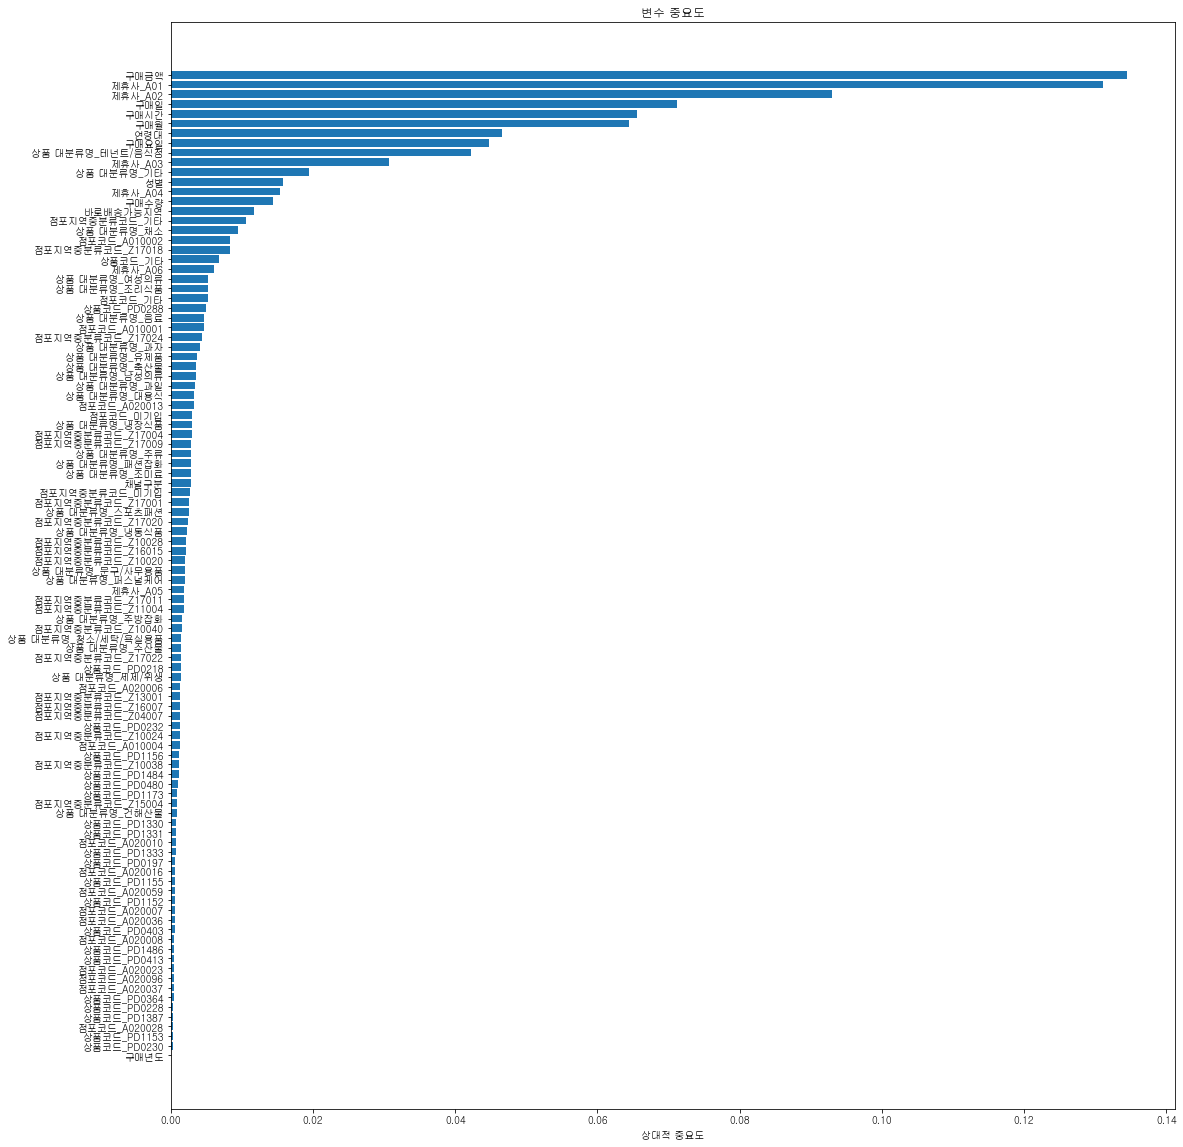

In [15]:
# 변수 중요도
rf = RandomForestClassifier(n_estimators = 100, 
                            random_state=0)

rf.fit(유통사_x_train,유통사_y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(18,20))
plt.title('변수 중요도')
plt.barh(range(len(indices)), importances[indices], color = 'tab:blue', align ='center')
plt.yticks(range(len(indices)), [pd.get_dummies(유통사_x_train).columns[i] for i in indices])
plt.xlabel('상대적 중요도')
plt.show()

In [16]:
# 결과
print(classification_report(유통사_y_test, pipe.predict(유통사_x_test), target_names = ['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.87      0.82      0.85      7356
     class 1       0.83      0.88      0.85      7355

    accuracy                           0.85     14711
   macro avg       0.85      0.85      0.85     14711
weighted avg       0.85      0.85      0.85     14711



In [17]:
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score
f1 = f1_score(유통사_y_test, y_pred) 
roc_auc = roc_auc_score(유통사_y_test, y_pred) 
print("F1 Score: {}".format(f1))
print("ROC AUC Score: {}".format(roc_auc))

F1 Score: 0.8541405062454563
ROC AUC Score: 0.8499781529361012


## 제휴사 모델링 - UnderSampling & RandomForest

In [18]:
from imblearn.under_sampling import RandomUnderSampler
copu_x_under, copu_y_under = RandomUnderSampler(random_state = 0).fit_resample(copu_x, copu_y)

In [19]:
copu_y_under = pd.DataFrame(copu_y_under)

In [20]:
from sklearn.model_selection import train_test_split
copu_x_train, copu_x_test, copu_y_train, copu_y_test = train_test_split(copu_x_under, copu_y_under, test_size=0.2, stratify = copu_y_under)

In [21]:
print(copu_x_train.shape, copu_y_train.shape)
print(copu_x_test.shape, copu_y_test.shape)

(33782, 62) (33782, 1)
(8446, 62) (8446, 1)


In [22]:
#컬럼 변환
numeric_features = copu_x.select_dtypes("int").columns.to_list()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [23]:
# random forest pipeline
pipe2 = make_pipeline(preprocessor,RandomForestClassifier(random_state=0))
pipe2.fit(copu_x_train, copu_y_train)
copu_y_pred_rf = pipe2.predict(copu_x_test)
print('테스트 정확도: %.4f'% pipe2.score(copu_x_test, copu_y_test))

테스트 정확도: 0.7472


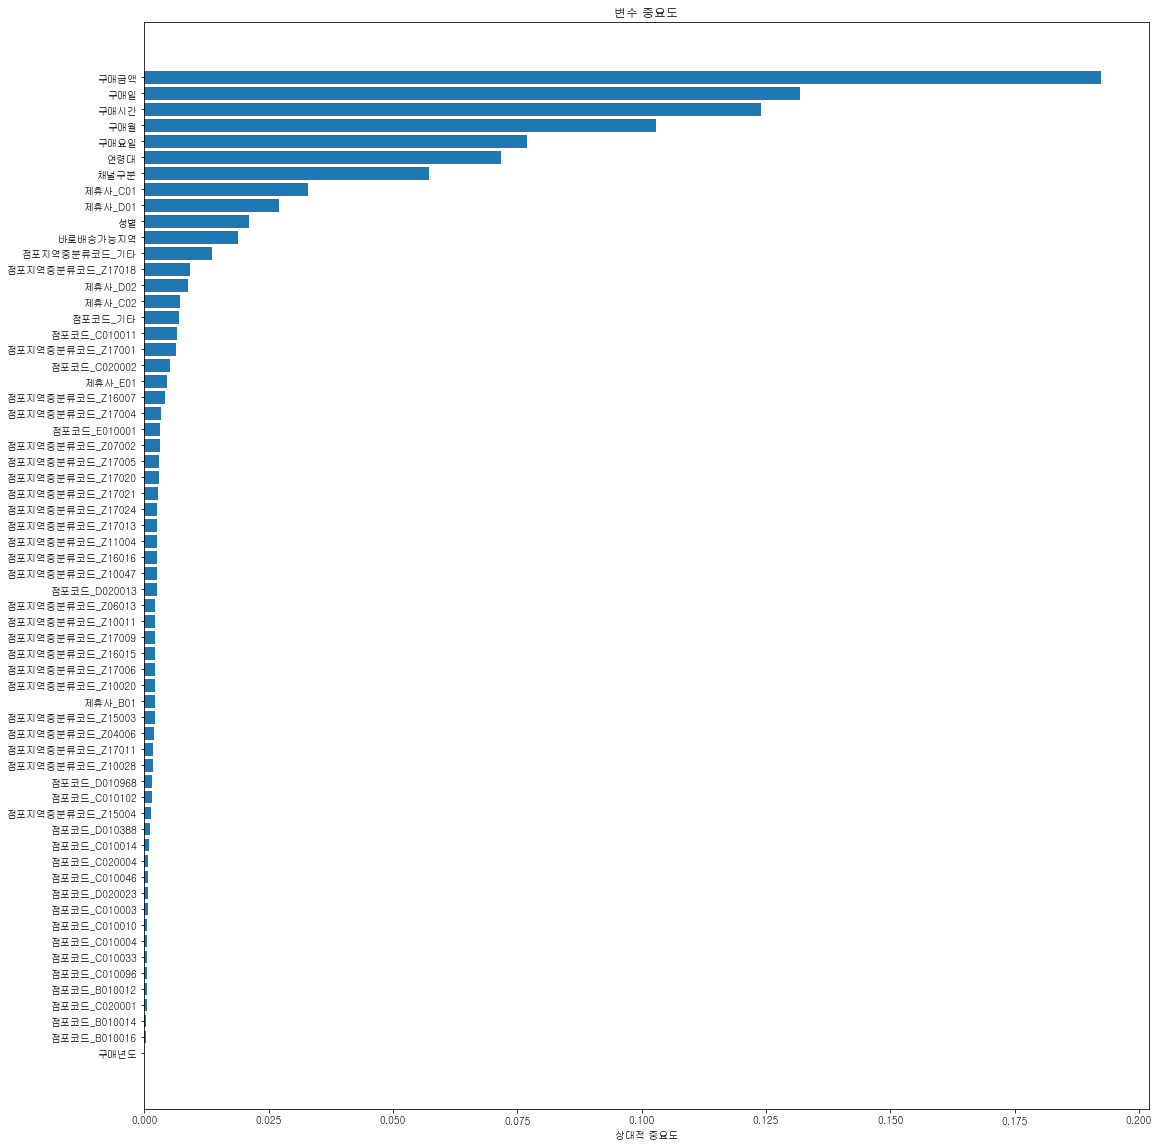

In [24]:
# 변수 중요도
rf2 = RandomForestClassifier(n_estimators = 100, 
                            random_state=0)
rf2.fit(copu_x_train,copu_y_train)
importances = rf2.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(18,20))
plt.title('변수 중요도')
plt.barh(range(len(indices)), importances[indices], color = 'tab:blue', align ='center')
plt.yticks(range(len(indices)), [pd.get_dummies(copu_x_train).columns[i] for i in indices])
plt.xlabel('상대적 중요도')
plt.show()

In [25]:
# 결과
print(classification_report(copu_y_test, pipe2.predict(copu_x_test), target_names = ['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.73      0.78      0.76      4223
     class 1       0.77      0.71      0.74      4223

    accuracy                           0.75      8446
   macro avg       0.75      0.75      0.75      8446
weighted avg       0.75      0.75      0.75      8446



In [26]:
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score
f1 = f1_score(copu_y_test, copu_y_pred_rf) 
roc_auc = roc_auc_score(copu_y_test, copu_y_pred_rf) 
print("F1 Score: {}".format(f1))
print("ROC AUC Score: {}".format(roc_auc))

F1 Score: 0.7380046631488526
ROC AUC Score: 0.747217617807246


# 모델 해석 & 마케팅 전략 제안

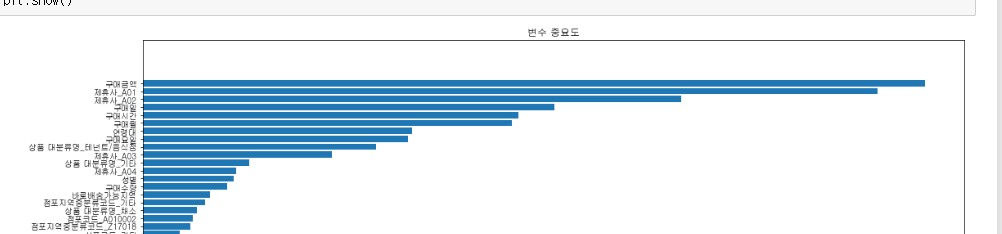

유통사의 경우, 구매금액, 제휴사 A01,A02, 구매일, 구매시간, 연령대, 구매요일 등 dummy로 제작된 변수보단, 
이미 존재했던 변수, 파생변수 등이 더 영향을 끼침.

즉, 아래 EDA를 통해 각 변수와 타겟과의 상관관계를 살펴보아야, 마케팅 전략 제안이 가능할 것으로 보임.

In [36]:
df_유통사_x = pd.concat([유통사_x_train,유통사_x_test])
df_유통사_y = pd.concat([유통사_y_train,유통사_y_test])
df_제휴사_x = pd.concat([copu_x_train,copu_x_test])
df_제휴사_y = pd.concat([copu_y_train,copu_y_test])

In [37]:
df_pdde_eda = pd.concat([df_유통사_x, df_유통사_y],axis=1)
df_copu_eda = pd.concat([df_제휴사_x, df_제휴사_y],axis=1)

In [29]:
df_pdde_eda = df_pdde_eda[['구매금액','제휴사_A01','제휴사_A02','구매일','구매시간','엘페이결제여부']]
df_copu_eda = df_copu_eda[['구매금액','구매일','구매시간','구매요일','연령대','엘페이결제여부']]

# 유통사 결과 해석

<AxesSubplot:xlabel='구매금액', ylabel='엘페이결제여부'>

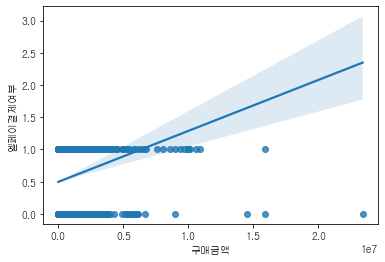

In [29]:
sns.regplot(x='구매금액', y='엘페이결제여부', data = df_pdde_eda, ci = 95)

In [30]:
def bar_chart_pdde(feature):
    Non_Use_Lpay = df_pdde_eda[df_pdde_eda['엘페이결제여부'] == 0][feature].value_counts()
    Use_Lpay = df_pdde_eda[df_pdde_eda['엘페이결제여부'] == 1][feature].value_counts()
    
    df_pdde_eda_using_lpay = pd.DataFrame([Non_Use_Lpay, Use_Lpay])
    df_pdde_eda_using_lpay.index = ['Non_Use_Lpay', 'Use_Lpay']
    df_pdde_eda_using_lpay.plot(kind = 'bar', stacked = True, figsize=(18,10))
    plt.xticks(rotation=0)

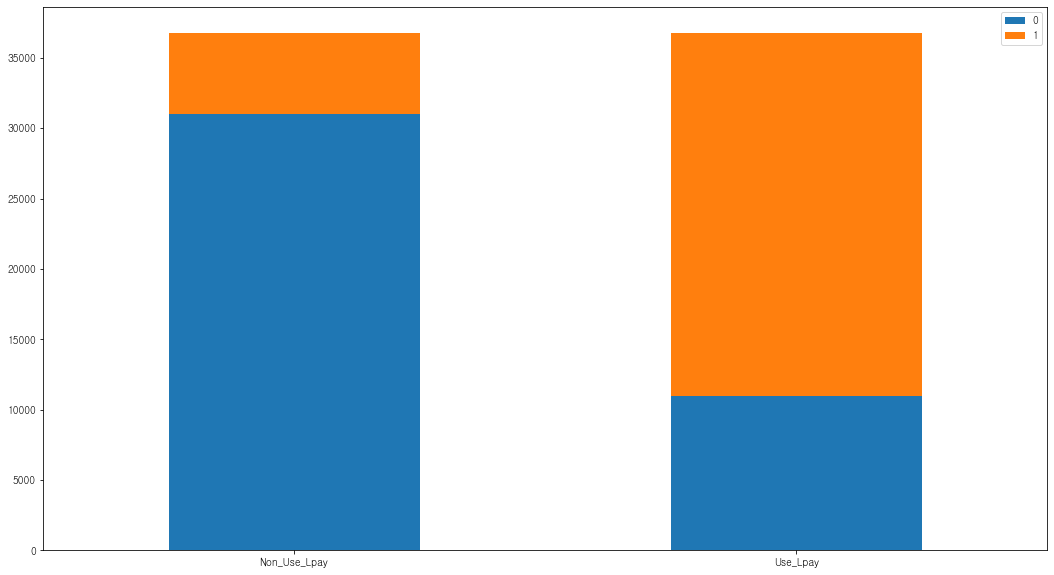

In [31]:
bar_chart_pdde('제휴사_A01')

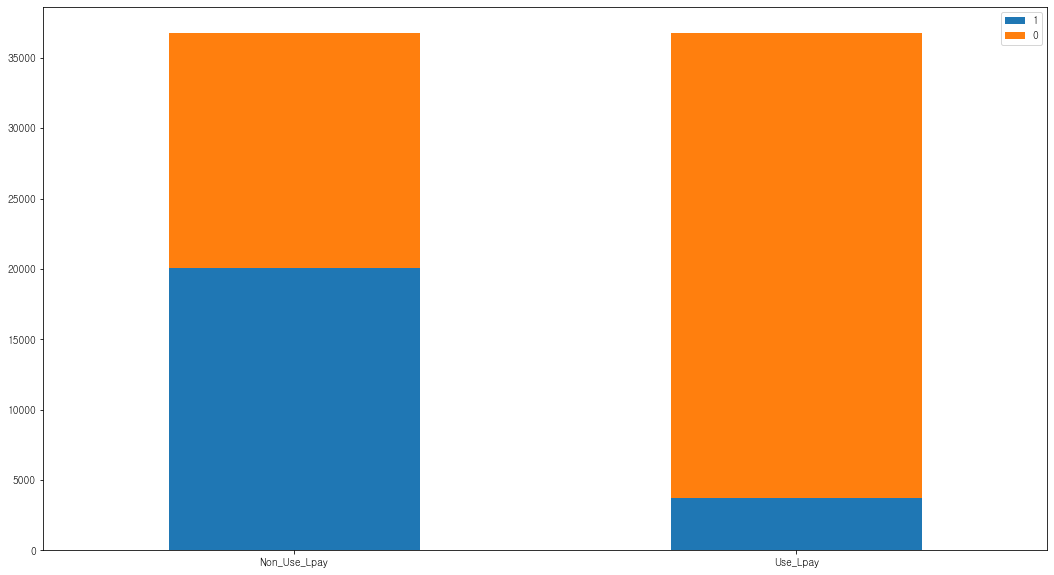

In [32]:
bar_chart_pdde('제휴사_A02')

In [34]:
df_pdde_eda[df_pdde_eda['엘페이결제여부']== 1]['제휴사_A01'].value_counts()

1    25798
0    10979
Name: 제휴사_A01, dtype: int64

In [35]:
df_pdde_eda[df_pdde_eda['엘페이결제여부']== 0]['제휴사_A01'].value_counts()

0    31039
1     5738
Name: 제휴사_A01, dtype: int64

<AxesSubplot:xlabel='구매일', ylabel='엘페이결제여부'>

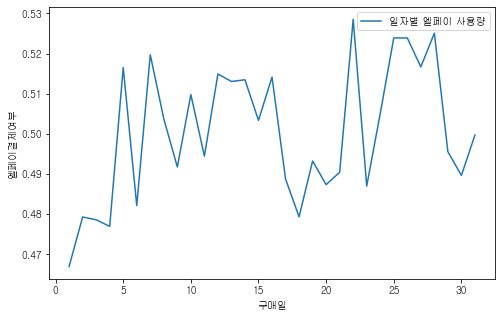

In [33]:
# 일자별 시각화 - 유통사
plt.figure(figsize = (8,5))
sns.lineplot(data=df_pdde_eda, x='구매일', y='엘페이결제여부', ci=None, label='일자별 엘페이 사용량')

<AxesSubplot:xlabel='구매시간', ylabel='엘페이결제여부'>

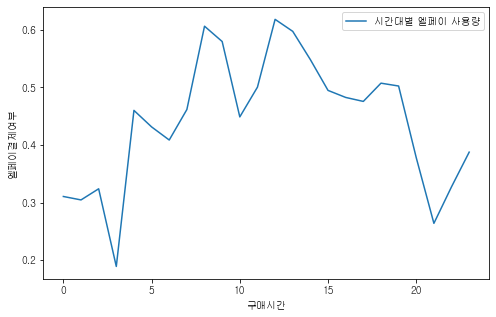

In [34]:
# 시간대별 시각화 - 유통사
plt.figure(figsize = (8,5))
sns.lineplot(data=df_pdde_eda, x='구매시간', y='엘페이결제여부', ci=None, label='시간대별 엘페이 사용량')

In [35]:
df_pdde_eda.describe()

,구매금액,제휴사_A01,제휴사_A02,구매일,구매시간,엘페이결제여부
count,7.355400e+04,73554.000000,73554.000000,73554.000000,73554.000000,73554.000000
mean,3.588144e+04,0.428746,0.323164,15.645009,15.404832,0.500000
std,2.637988e+05,0.494900,0.467688,8.819835,3.529533,0.500003
min,2.000000e+01,0.000000,0.000000,1.000000,0.000000,0.000000
25%,3.000000e+03,0.000000,0.000000,8.000000,13.000000,0.000000
50%,6.600000e+03,0.000000,0.000000,16.000000,16.000000,0.500000
75%,1.580000e+04,1.000000,1.000000,23.000000,18.000000,1.000000
max,2.340000e+07,1.000000,1.000000,31.000000,23.000000,1.000000


In [47]:
df_pdde_eda[df_pdde_eda['엘페이결제여부'] == 1]['구매일'].value_counts()

5     1330
16    1310
17    1278
19    1272
27    1256
4     1250
24    1249
22    1242
13    1240
6     1238
26    1229
7     1228
10    1226
25    1217
20    1211
15    1207
11    1200
3     1194
1     1179
23    1177
21    1175
14    1164
9     1157
18    1157
2     1132
12    1124
29    1106
30    1084
8     1084
28    1079
31     782
Name: 구매일, dtype: int64

In [48]:
df_pdde_eda[df_pdde_eda['엘페이결제여부'] == 1]['구매시간'].value_counts()

12    4368
13    4084
18    3744
14    3581
17    3487
15    3450
16    3446
19    3278
11    2175
20    1656
10    1006
21     684
9      470
22     448
8      377
23     162
7      120
0       82
1       46
6       38
2       23
4       23
5       22
3        7
Name: 구매시간, dtype: int64

# 제휴사 결과해석

<AxesSubplot:xlabel='구매금액', ylabel='엘페이결제여부'>

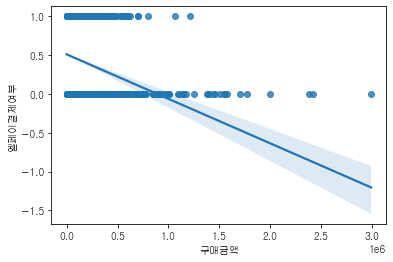

In [36]:
sns.regplot(x='구매금액', y='엘페이결제여부', data = df_copu_eda, ci = 95)

<AxesSubplot:xlabel='구매일', ylabel='엘페이결제여부'>

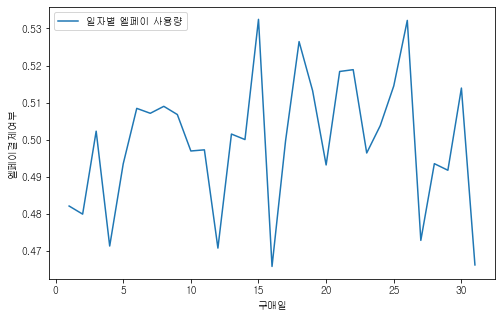

In [37]:
# 일자별 시각화 - 제휴사
plt.figure(figsize = (8,5))
sns.lineplot(data=df_copu_eda, x='구매일', y='엘페이결제여부', ci=None, label='일자별 엘페이 사용량')

<AxesSubplot:xlabel='구매시간', ylabel='엘페이결제여부'>

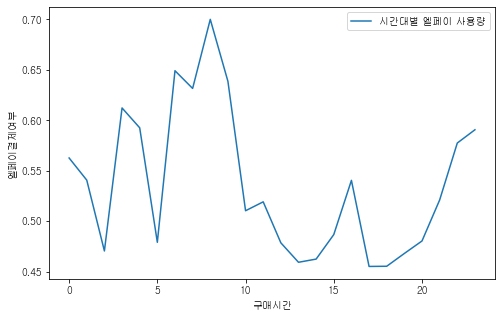

In [38]:
# 시간대별 시각화 - 제휴사
plt.figure(figsize = (8,5))
sns.lineplot(data=df_copu_eda, x='구매시간', y='엘페이결제여부', ci=None, label='시간대별 엘페이 사용량')

In [39]:
def bar_chart_copu(feature):
    Non_Use_Lpay = df_copu_eda[df_copu_eda['엘페이결제여부'] == 0][feature].value_counts()
    Use_Lpay = df_copu_eda[df_copu_eda['엘페이결제여부'] == 1][feature].value_counts()
    
    df_pdde_eda_using_lpay = pd.DataFrame([Non_Use_Lpay, Use_Lpay])
    df_pdde_eda_using_lpay.index = ['Non_Use_Lpay', 'Use_Lpay']
    df_pdde_eda_using_lpay.plot(kind = 'bar', stacked = True, figsize=(18,10))

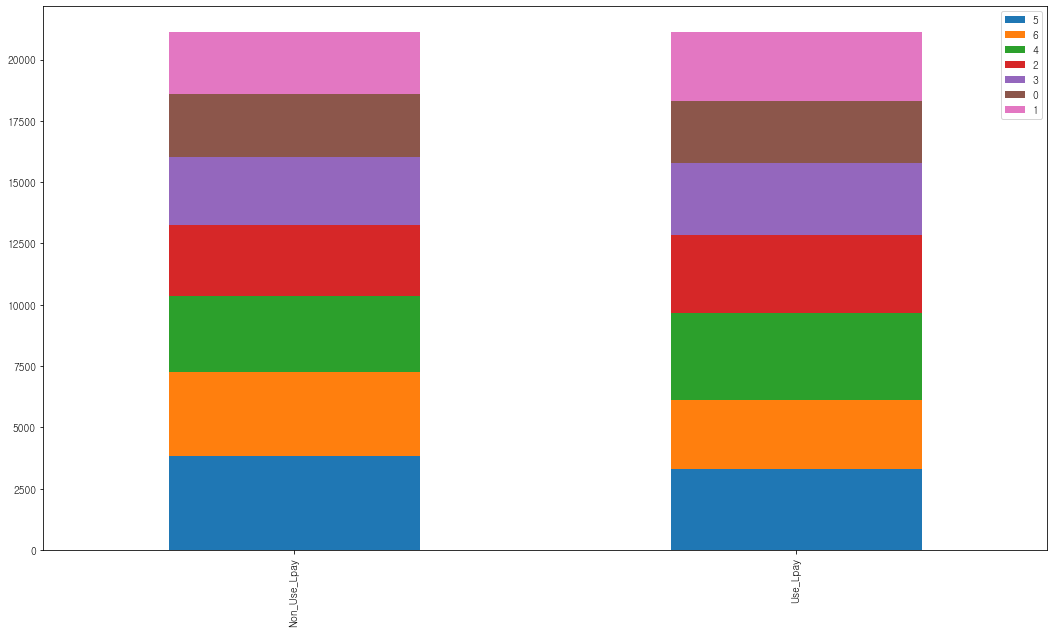

In [40]:
bar_chart_copu('구매요일')

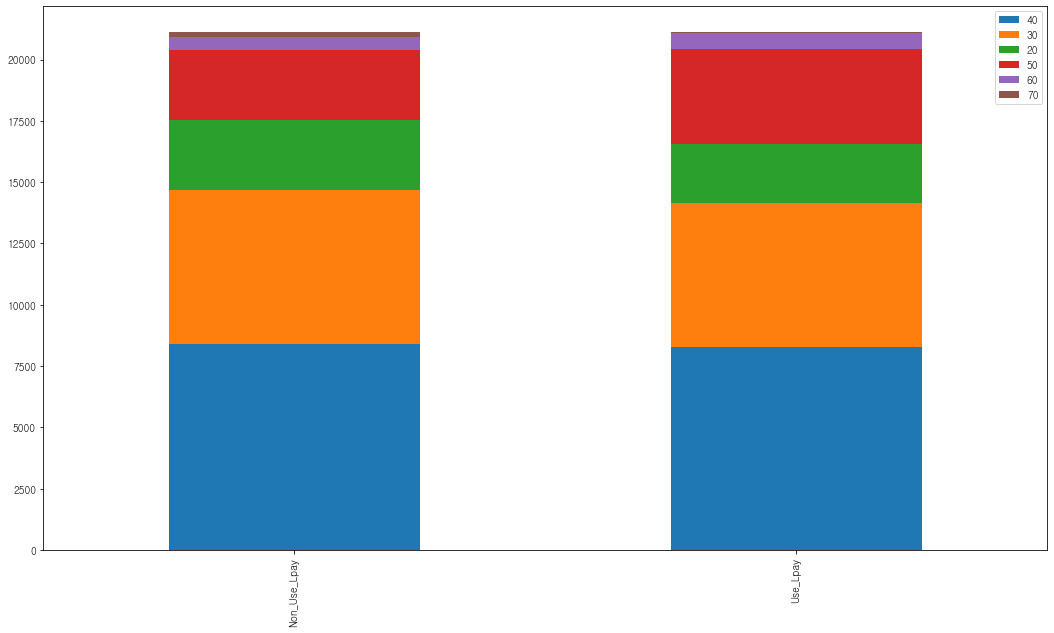

In [41]:
bar_chart_copu('연령대')

In [180]:
pdde_test = pd.concat([유통사_x_test, 유통사_y_test],axis=1)
copu_test = pd.concat([copu_x_test, copu_y_test],axis=1)
pdde_y_pred = pd.DataFrame(y_pred)
copu_y_pred = pd.DataFrame(copu_y_pred_rf)

In [190]:
pdde_test.to_pickle('pdde_test.pkl')
copu_test.to_pickle('copu_test.pkl')
pdde_y_pred.to_pickle('pdde_y_pred.pkl')
copu_y_pred.to_pickle('copu_y_pred.pkl')

In [198]:
# 모델저장
with open('유통사 모델링.pickle','wb') as fw_pdde:
    pickle.dump(rf, fw_pdde)
with open('제휴사 모델링.pickle', 'wb') as fw_copu:
    pickle.dump(rf2, fw_copu)